#Dissipative Driven Entanglement Notebook
Author: Eugene Dumitrescu

In this notebook we (loosely) follow the prescription of Refs[1,2] to simulate the dynamical entanglement of QD systems coupled to a quantum environment. The approach taken is based on cavity QED, however our aim is to replace the cavity with a plasmonic reservoir.

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from qutip import *

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)


# operators acting on the composite spin-boson Hilbert space
def I(N,M):
    """Identity"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

# spin operators
def sx(i, N, M):
    """Pauli X on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    """Pauli Y on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    """Pauli Z on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    """destroy quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    """create quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i,N,M):
    """dipole operator for ith spin"""
    return sp(i, N, M) + sm(i, N, M)

# plasmon / EM mode operators
def a(N, M):
    """bosonic annihiliation operator"""
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def n_a(N,M):
    """bosonic number operator"""
    return a(N,M).dag() * a(N,M)

def d_a(N,M):
    """bosonic dipole operator"""
    return a(N,M).dag() + a(N,M)

# spin subspace projection operators 
def P_S(N,M):
    """Symmetric |s = 1, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))

def P_A(N,M):
    """Anti-symmetric |s = 0, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))

def P_pp(N,M):
    """|++> subspace projector """
    return np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])

def P_mm(N,M):
    """|--> subspace projector """
    return np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])


## Hamiltonian and Model

Our model Hamiltonian for a N two levels systems (TLS) interacting with a bosonic reservoir is 
<center> $H = H_0 + H_{int} + H_{drv}$ </center>
where the individual, interacting, and driving components of the Hamiltonian are given by 
<center>
$\displaystyle H_0 = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a$
</center>
<center>
$\displaystyle H_{int} = - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger)$
</center>
<center>
$\displaystyle H_{drv} = - \sum_{i}^N \Omega_i \hat{d}_i + \Omega_a \hat{d}_a$
</center>
We have used the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$  in the driving term and we have also applied the rotating wave approximation.

In [2]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes
lam = 2        # constant that all other constants are given in terms of

ws = [0.020, -0.020, 0.0]    # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

def Ham(ws,gs,ds):
    """ Define the Hamiltonian as a function of the above parameters """
    H_0   = sum(ws[i] * sp(i,N,M) * sm(i,N,M) for i in range(N)) + ws[N] * n_a(N,M)
    H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
    H_DRV = sum(ds[i] * d(i,N,M) for i in range(N)) + ds[N] * d_a(N,M)
    return H_0 - H_RWA - H_DRV

# Lindblad dissipation parameters
kap   = 1 * lam           # cavity relaxation rate
gam   = 1 * kap / 1e8       # atom relaxation rate
gdph  = 2 * kap / 1e8       # atom dephasing rate 
n_th  = 0.0               # thermal cavity occupation number 

def cops(kappa, gamma, deph, n_th):
    """
    Define collapse operators for Lindblad master equation
    
    Parameters
    ----------
    kappa: cavity relaxation rate,  ~ 500 THz ~ 2 eV
    gamma: emitter relaxation rate, ~ 10 MHz ~ 1mueV
    gdph: emitter dephasing rate,   ~ same as relaxation rate
    n_th: temperature for entire system, gives excitation rate

    Returns
    -------
    c_ops: list of collapse operators
    """
    c_ops = []
    for i in range(2):
        rate = np.sqrt(gamma * (1 + n_th))
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M))        # relaxation
        rate = gamma * n_th
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M).dag())  # excitation
        c_ops.append(np.sqrt(deph) * sz(i,N,M))   # dephasing  
    rate = np.sqrt(kappa * (n_th + 1))
    if rate > 0: 
        c_ops.append(rate * a(N,M))
    rate = np.sqrt(kappa * (n_th))
    if rate > 0: 
        c_ops.append(rate * a(N,M).dag())
    return c_ops

def g2(sta, ham, lin, tim):
    """
    Parameters
    ----------
    sta: initial state to evolve according to 
    ham: Hamiltonian matrix and 
    lin: Limbladian operators for 
    tim: times 
    
    Returns
    -------
    g^(2)(tau) second order correlation function
    """
    e_ss_ops = [sp(i,N,M) * sm(i,N,M) for i in range(N)]        # qubit occupation number operators
    
    rho_ae = [sm(i,N,M) * rho_ss * sp(i,N,M) for i in range(N)] # track all possible emission events
#   rho_ae = [r/r.tr() for r in rho_ae]                         # renormalize states
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(ham, r, taus, lin, e_ss_ops) for r in rho_ae]
    
    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * rho_ss).tr()) for e in e_ss_ops]  
    return sum(results[i].expect[j] / (denoms[i] * denoms[j]) / float(N**2) for i in range(N) for j in range(N))


# Dynamical Evolution

Let us initialize system with one dot excited and the other in the ground state and allow the system to evolve dissipatively. Short lived entanglement, as measured by the concurrence, should be generated between the dots; although asymmetric couplings may be needed to realize the expected result. 


## Master Eqaution:

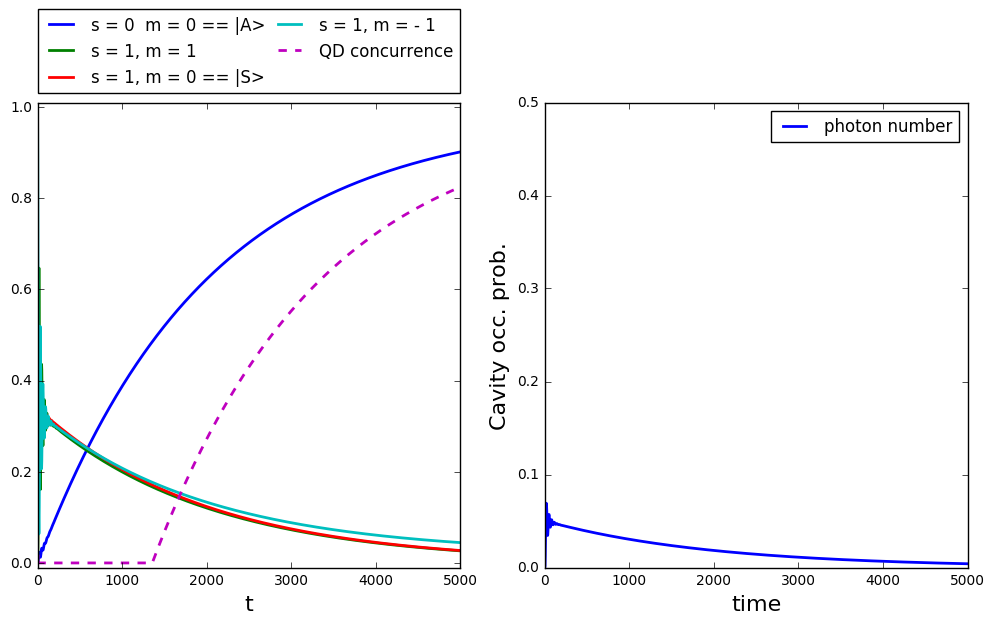

In [54]:
# Initial state
psi_0 = basis(2,1)                   # qb 1  ground state
psi_1 = basis(2,1)                   # qb 2 excited state
psi_c = basis(M,0)                   # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)  # tensor product

# discretized time domain
tlist = np.linspace(0,5e3, 2e3)

# run dynamics solver
result = mesolve(Ham(ws,gs,ds), psi_tot, tlist, cops(kap, gam, gdph, n_th), [])

# expectation value operators: subspace occupation number projectors and concurrence
e_ops = [P_S(N,M), P_A(N,M), P_pp(N,M), P_mm(N,M), n_a(N,M)]
Ex_P_S, Ex_P_A, Ex_Ppp, Ex_Pmm, Ex_n_a = [[expect(e,st) for st in result.states] for e in e_ops]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

#plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))

times = tlist      # renormakize time units
axes[0].plot(times, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0 == |A>")
axes[0].plot(times, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(times, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0 == |S>")
axes[0].plot(times, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(times, concr , '--', linewidth=2, label="QD concurrence")
axes[0].set_ylim(-.01,1.01)
axes[0].set_xlabel("t", fontsize=16)
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(times, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, .5)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()

# Correlations

We proposed to optically characterize the entanglement generated in our device by means of the normalized second order coherence function:

<center>
$\displaystyle g^2(r_1,t_1;r_2,t_2) = \frac{\langle a^\dagger (r_1,t_1) a^\dagger (r_2,t_2) a(r_2,t_2) a(r_1,t_1) \rangle}{\langle a^\dagger(r_1,t_1) a(r_1,t_1) \rangle \langle a^\dagger(r_2,t_2) a(r_2,t_2) \rangle}$
</center>

Suppose we probe light from the same spatio-temporal source (i.e. a stationary process with $r_1=r_2$) and introduce a time delay denoted by $\tau = t_2 - t_1$. In this case $g^2$ does not depend on $t_1$ and $t_1$ but only on their difference $\tau$. We can then express the second order coherence function in the following form:

<center>
$\displaystyle g^2(t, \tau) = \frac{\langle a^\dagger (t) a^\dagger (t + \tau) a(t + \tau) a(t) \rangle}{\langle a^\dagger(t) a(t) \rangle^2}$
</center>

Below we show 2 coherence functions. In the first $t$ is set to $0$ such that $g^2(0,\tau)\equiv g^2(\tau)$ and correlations are therefore calculated with respect to the initial (Fock state) of the cavity. One may also calculate the correlation function in the limit $t \rightarrow \infty$ such that the correlations are calculated with respect to the steady state solution (provided such a solution exists).


# Numerical Solution

In order to calculate the second order correlation function we follow the following procedure

- Take the steady state $\rho_{ss}$ and simulate an emission event by destroying a single quanta of energy 
    - Note this could technically occur in either of the emitters *or* in the plasmonic cavity. For now we assume the emitters are responsible for the spontaneous emission. 
- Evolve the system in time and renormalize by the steady state $g^2$ denominator
    


## compare $g^{(2)}(0)$ vs the concurrence

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


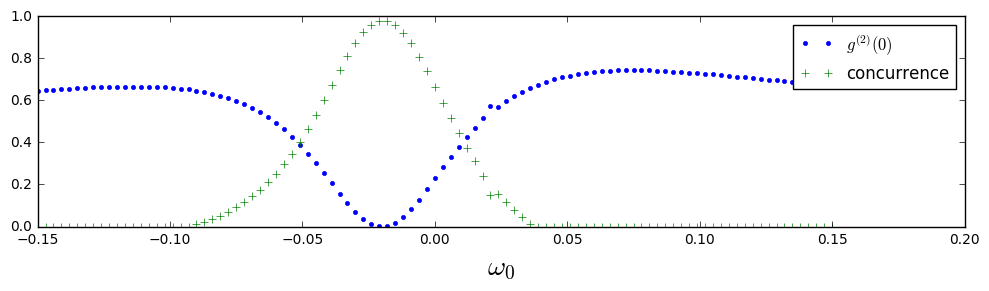

In [9]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,1.5e2, 2e3)

# parameter range
num = 101
w_range = np.linspace(-.15, 0.15, num)
wss = [[0.02, w, 0.0] for w in w_range]
g2zd = [0] * num
cnc = [0] * num

for i in range(num):
    # density matrices before emission (steady state) and after emission (ae)
    rho_ss = steadystate(Ham(wss[i], gs, ds), cops(kap, gam, gdph, n_th))
    cnc[i] = concurrence(ptrace(rho_ss,[0,1]))   # steady state concurrence
    
    rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
    rho_ae = [r/r.tr() for r in rho_ae]
    g2zd[i] = sum((e_op * r).tr() for e_op in e_ss_ops for r in rho_ae)
    
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.set_xlabel('$\omega_0$', fontsize=20)
# plt.colorbar(mpbl)
ax.plot(w_range, g2zd, '.', label = '$g^{(2)}(0)$')
ax.plot(w_range, cnc, '+', label = 'concurrence')
plt.tight_layout()
plt.legend()
# plt.savefig("g2_detuning_diagram.pdf")
plt.show()

# Zero delay Phase diagram

Now perform the same calculation as above but in the entire omega_0, omega_1 plane

In [114]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))

def g2_0(r_ss):
    """probability for two simultaneous emission events given an input state r_ss"""
    return sum((sm(i,N,M) * sm(j,N,M) * r_ss * sp(j,N,M) * sp(i,N,M)).tr() 
        / (4 * (e_ss_ops[i] * r_ss).tr() * (e_ss_ops[j] * r_ss).tr()) for i in range(2) for j in range(2))

In [3]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes

ws = [0.02, -0.02, 0.0]       # frequency/level spacing of each individual system
gs = [0.099, 0.101]          # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

# Lindblad dissipation parameters
kap   = 1                 # cavity relaxation rate
gam   = 1 * kap/1e6   # atom relaxation rate
gdph  = 2 * kap/1e6       # atom dephasing rate 

# detuning range
N_w = 51
w_r = 0.5
x_range = np.linspace(-w_r,w_r,N_w)
y_range = np.linspace(-w_r,w_r,N_w)

# calculate steady state concurrence
rho_sss = [[steadystate(Ham([w0, w1, 0], gs, ds),
                        cops(kap, gam, gdph, n_th)) for w0 in x_range] for w1 in y_range[::-1]]
g2zds = np.array([[g2_0(rho_sss[i][j]) for i in range(N_w)] for j in range(N_w)])

fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.imshow(np.real(g2zds), cmap='hot', interpolation='nearest', extent=[min(x_range),max(x_range),min(y_range),max(y_range)])
ax.set_xlabel('$\Delta_0$')
ax.set_ylabel('$\Delta_1$')
plt.colorbar(fraction = 0.045) # fraction controls legend bar size
plt.tight_layout()
plt.show()

NameError: name 'g2_0' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.imshow(np.real(g2zds), cmap='hot', interpolation='nearest', extent=[min(x_range),max(x_range),min(y_range),max(y_range)])
ax.set_xlabel('$\Delta_0$')
ax.set_ylabel('$\Delta_1$')
plt.colorbar(fraction = 0.045)
plt.tight_layout()
plt.show()

Perform a similar calculation calculating the zero-delay relaxation timescale... this should be proportional to the timescales for 'reaching' the steady state


# Full width half-maximum timescales

In order for the anti-bunching effect be experimentally discernable, the anti-bunching should occur on an $\mathcal{O}(ns)$ timescale. Seeing this effect would not be possible if the anti-buching were to occur on, for example, an ultra-fast $fs$ timescale.

Not that it is difficult to identify the full-width half maximum because the maximum may actually occur at relaxation timescales. That is, no local maxima from "beading" is seen before the onset of long time relaxation -- back to unity as required in the long time limit. This means that the driving frequency is masked by the relaxation frequency. However we can still try to extract this feature by Fourier forming the transient signal and extracting the effectiv Rabi driving frequency numerically.  


In [142]:
# discretized g2 time domain
taus = np.linspace(0,5e3, 2e3)

# density matrices before emission (steady state) and after emission (ae)
rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))


num = 51
g_range = np.linspace(0.01, 0.2, num)

datas = [g2(rho_ss, Ham(ws, gs, [d,d,0]), cops(kap, gam, gdph, n_th), taus) for d in g_range]
datass = [g2(rho_ss, Ham(ws, gs, [0.1,0.1,d]), cops(kap, gam, gdph, n_th), taus) for d in g_range]

maxs = [np.argmax(d) for d in datas]
maxss = [np.argmax(d) for d in datass]

# plt.plot(taus, datas[20], 'g--')
# plt.show()

plt.plot(maxs)
plt.plot(maxss)
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

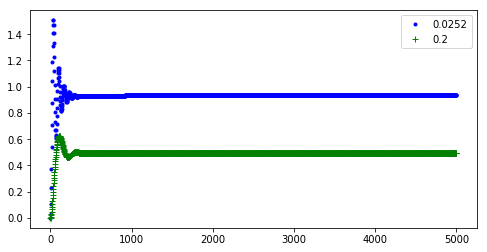

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (8,4))
plt.plot(taus, datas[10], 'b.', label =  str(g_range[4]))
plt.plot(taus, datas[1], 'g+', label =  str(g_range[50]))

plt.legend()
plt.show()


# Fourier transformations, frequencies, and timescales

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


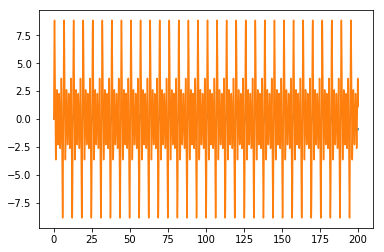

In [264]:
om = 1      # angular frequency

steps = 1e6
tmax = 2e2
taus = np.linspace(0, tmax, steps)
sig1 = np.sin(om * taus)


sig2 = sum(n * np.sin(n * om * taus) for n in range(5))

plt.plot(taus, sig1)
plt.plot(taus, sig2)
plt.show()


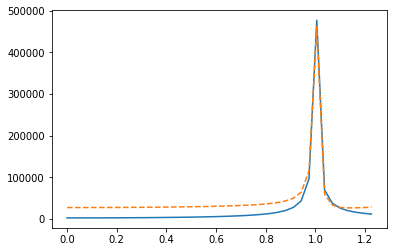

In [265]:
I1   = np.abs(np.fft.fft(sig1))                                # power spectrum
I2   = np.abs(np.fft.fft(sig2))                                # power spectrum
frqs = [2 * np.pi * i / tmax for i in range(int(steps))] # frequencies

zm = 40    # zoom into low frequency limit
plt.plot(frqs[:zm],I1[:zm], '-')
plt.plot(frqs[:zm],I2[:zm], '--')
plt.show()


In [266]:
omega = 2 * np.pi * np.argmax(I1[:int(steps/2)]) / tmax
2 * np.pi / omega, omega, steps



(6.2499999999999991, 1.0053096491487339, 1000000.0)

# Finite Delay characteristic anti-bunching timescales

It is difficult to identify the full-width half maximum because the maximum may actually occur at relaxation timescales. That is, no local maxima from "beading" is seen before the onset of long time relaxation -- back to unity as required in the long time limit. This means that the driving frequency is masked by the relaxation frequency. However we can still try to extract this feature by Fourier forming the transient signal and extracting the effectiv Rabi driving frequency numerically.  

We study the anti-bunching lifetime as a function of:
1. Detuning
2. Coupling strength
3. Driving amplitude -- good lead. This seems to be effective



/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


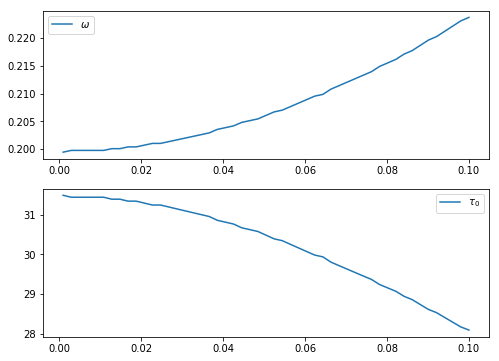

In [17]:
# density matrices before emission (steady state) and after emission (ae)
rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))

num = 51
g_range = np.linspace(0.001, 0.1, num)

# discretized g2 time domain
steps = 4e3
tmax = 2e4
taus = np.linspace(0, tmax, steps)

# g2s = [g2(rho_ss, Ham(ws, gs, [d,d,0]), cops(kap, gam, gdph, n_th), taus) for d in g_range]
g2s = [g2(rho_ss, Ham([d, -d, 0], ds, ds), cops(kap, gam, gdph, n_th), taus) for d in g_range]
g2s = [g/g[-1] for g in g2s] # take care of weird messed up normalization constant

power_specs = [np.abs(np.fft.fft(g)) for g in g2s]
main_modes = [np.argmax(ps[1:int(steps/2)]) for ps in power_specs]
freqs = [2 * np.pi * mm / tmax for mm in main_modes]
times = [2 * np.pi / f for f in freqs]

fig, ax = plt.subplots(2, 1, figsize = (8,6))
ax[0].plot(g_range, freqs, label = '$\omega$')
ax[0].legend()
ax[1].plot(g_range, times, label = '$\\tau_0$')
ax[1].legend()
plt.show()

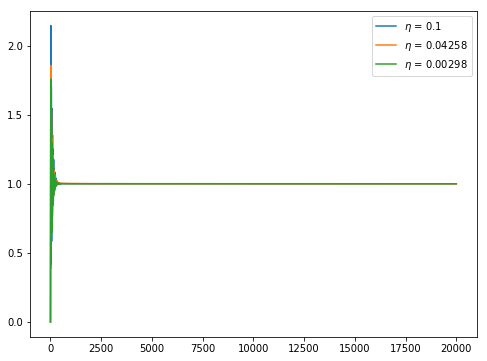

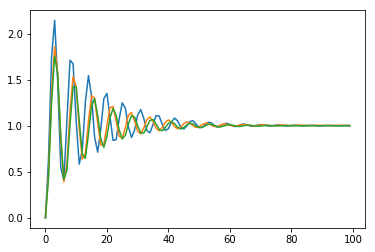

In [18]:
ns = [1, 21, 50]
ns.reverse()

fig, ax = plt.subplots(1, 1, figsize = (8,6))

for n in ns:
    plt.plot(taus, g2s[n], label = '$\eta$ = ' + str(g_range[n]))
plt.legend()
plt.show()

# plot first n steps
lim = 100
gss = [g2s[n] for n in ns]
for g in gss:
    plt.plot(g[:lim])
plt.show()

### Frequency phase diagrams


In [ ]:
# density matrices before emission (steady state) and after emission (ae)
rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))

g_steps = 21
g_range = np.linspace(0.001, 0.1, g_steps)

eta_steps = 11
eta_range = np.linspace(0.001, 0.2, eta_steps)

# discretized g2 time domain
steps = 4e3
tmax = 2e4
taus = np.linspace(0, tmax, steps)

g2s = [g2(rho_ss, Ham(ws, gs, [d,d,0]), cops(kap, gam, gdph, n_th), taus) for d in g_range]
# g2s = [g2(rho_ss, Ham([d,-d,0], gs, ds), cops(kap, gam, gdph, n_th), taus) for d in g_range]
g2s = [g/g[-1] for g in g2s] # take care of weird messed up normalization constant

power_specs = [np.abs(np.fft.fft(g)) for g in g2s]
main_modes = [np.argmax(ps[1:int(steps/2)]) for ps in power_specs]
freqs = [2 * np.pi * mm / tmax for mm in main_modes]
times = [2 * np.pi / f for f in freqs]

fig, ax = plt.subplots(2, 1, figsize = (8,6))
ax[0].plot(g_range, freqs, label = '$\omega$')
ax[0].legend()
ax[1].plot(g_range, times, label = '$\\tau_0$')
ax[1].legend()
plt.show()